<a href="https://colab.research.google.com/github/matule00/SGE/blob/main/cena_RE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, LeakyReLU, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

import statsmodels.formula.api as smf


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 220)

In [67]:
SVR = pd.read_csv('SVR_11_12.csv')
SVR['Time'] = pd.to_datetime(SVR['Time'])

SO = pd.read_csv('odchylka_moje.csv')
SO['Time'] = pd.to_datetime(SO['Time'])

RE = pd.read_csv('RE_cena_moje.csv')
RE['Time'] = pd.to_datetime(RE['Time'])

vymena = pd.read_csv('SVR_vymena_moje.csv')
vymena['Time'] = pd.to_datetime(vymena['Time'])

data = pd.merge(RE, SO, on='Time')

data = pd.merge(data, SVR, on='Time')
data = pd.merge(data, vymena, on='Time')

data = data.dropna()

data.drop(columns=['rr_p', 'rr_m', 'mFRR+ [eur]', 'mFRR- [eur]', 'mFRR5 [eur]', 'mfrr_p', 'mfrr_m'], inplace=True)
data.rename(columns={'Aktuální odchylka [MW]': 'SO', 'aFRR [eur]': 'cena'}, inplace=True)
data['cena'] = pd.to_numeric(data['cena'], errors='coerce')
data['Picasso'] = pd.to_numeric(data['Picasso'], errors='coerce')
data['ImbalanceNetting'] = pd.to_numeric(data['ImbalanceNetting'], errors='coerce')
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

print(data.head())
print(data.describe(include='all'))

                 Time       cena         SO    afrr_p  afrr_m  mfrr5  ImbalanceNetting   Picasso
0 2024-11-28 09:06:00  237.64984 -65.543770  75.02734     0.0    0.0          -1.32460  25.48119
1 2024-11-28 09:07:00  187.94983 -42.624687  77.96964     0.0    0.0          -1.10645  25.55397
2 2024-11-28 09:08:00  169.51376 -15.013090  76.93359     0.0    0.0          -1.10582  40.33277
3 2024-11-28 09:09:00  167.33347  -0.357384  75.89848     0.0    0.0          -1.09216  57.72522
4 2024-11-28 09:10:00  167.19435 -10.509396  75.14953     0.0    0.0          -1.29164  36.31295
                                Time          cena            SO        afrr_p        afrr_m         mfrr5  ImbalanceNetting       Picasso
count                          15864  15864.000000  15864.000000  15864.000000  15864.000000  15864.000000      15864.000000  15864.000000
mean   2024-12-03 23:55:16.970499328    109.031564    -19.631263     17.736838     -2.754257      0.018313        -14.598047      9.725130
m

In [69]:
data = data.sort_values(by='Time')
data = data.set_index('Time')

expected_interval = pd.Timedelta(minutes=1)  # Adjust based on your data
full_time_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq=expected_interval)
data = data.reindex(full_time_range)

numeric_columns = data.select_dtypes(include='number').columns
data[numeric_columns] = data[numeric_columns].interpolate(method='linear')

data = data.reset_index()
data.rename(columns={'index': 'Time'}, inplace=True)

print("Data after filling missing intervals:")
print(data.head())

Data after filling missing intervals:
                 Time       cena         SO    afrr_p  afrr_m  mfrr5  ImbalanceNetting   Picasso
0 2024-11-28 09:06:00  237.64984 -65.543770  75.02734     0.0    0.0          -1.32460  25.48119
1 2024-11-28 09:07:00  187.94983 -42.624687  77.96964     0.0    0.0          -1.10645  25.55397
2 2024-11-28 09:08:00  169.51376 -15.013090  76.93359     0.0    0.0          -1.10582  40.33277
3 2024-11-28 09:09:00  167.33347  -0.357384  75.89848     0.0    0.0          -1.09216  57.72522
4 2024-11-28 09:10:00  167.19435 -10.509396  75.14953     0.0    0.0          -1.29164  36.31295


In [58]:
std = data['cena'].std()
mean = data['cena'].mean()
print(f"Standard Deviation: {std}")
print(f"Mean: {mean}")
print(data[-data['cena'] > mean + 23 * std])

Standard Deviation: 80.64746155162406
Mean: 109.03156378530005
Empty DataFrame
Columns: [Time, cena, SO, afrr_p, afrr_m, mfrr5, ImbalanceNetting, Picasso]
Index: []


In [9]:
data['cena_shifted'] = data['cena'] - data['cena'].min() + 1  # Shift to make positive
model_shifted = smf.ols(formula="np.log(cena_shifted) ~ SO + afrr_p + afrr_m + mfrr5 + ImbalanceNetting + Picasso", data=data).fit()
print(model_shifted.summary())

                             OLS Regression Results                             
Dep. Variable:     np.log(cena_shifted)   R-squared:                       0.627
Model:                              OLS   Adj. R-squared:                  0.627
Method:                   Least Squares   F-statistic:                     4450.
Date:                  Wed, 18 Dec 2024   Prob (F-statistic):               0.00
Time:                          12:57:35   Log-Likelihood:                 4907.1
No. Observations:                 15864   AIC:                            -9800.
Df Residuals:                     15857   BIC:                            -9746.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           

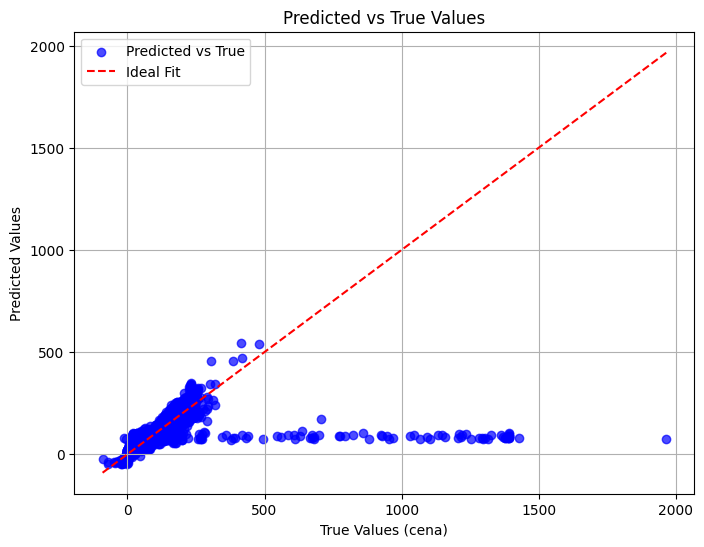

In [10]:
data['predicted'] = np.exp(model_shifted.predict(data)) + data['cena'].min() - 1

plt.figure(figsize=(8, 6))
plt.scatter(data['cena'], data['predicted'], alpha=0.7, color='blue', label='Predicted vs True')
plt.plot([data['cena'].min(), data['cena'].max()], [data['cena'].min(), data['cena'].max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('True Values (cena)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values')
plt.legend()
plt.grid()
plt.show()

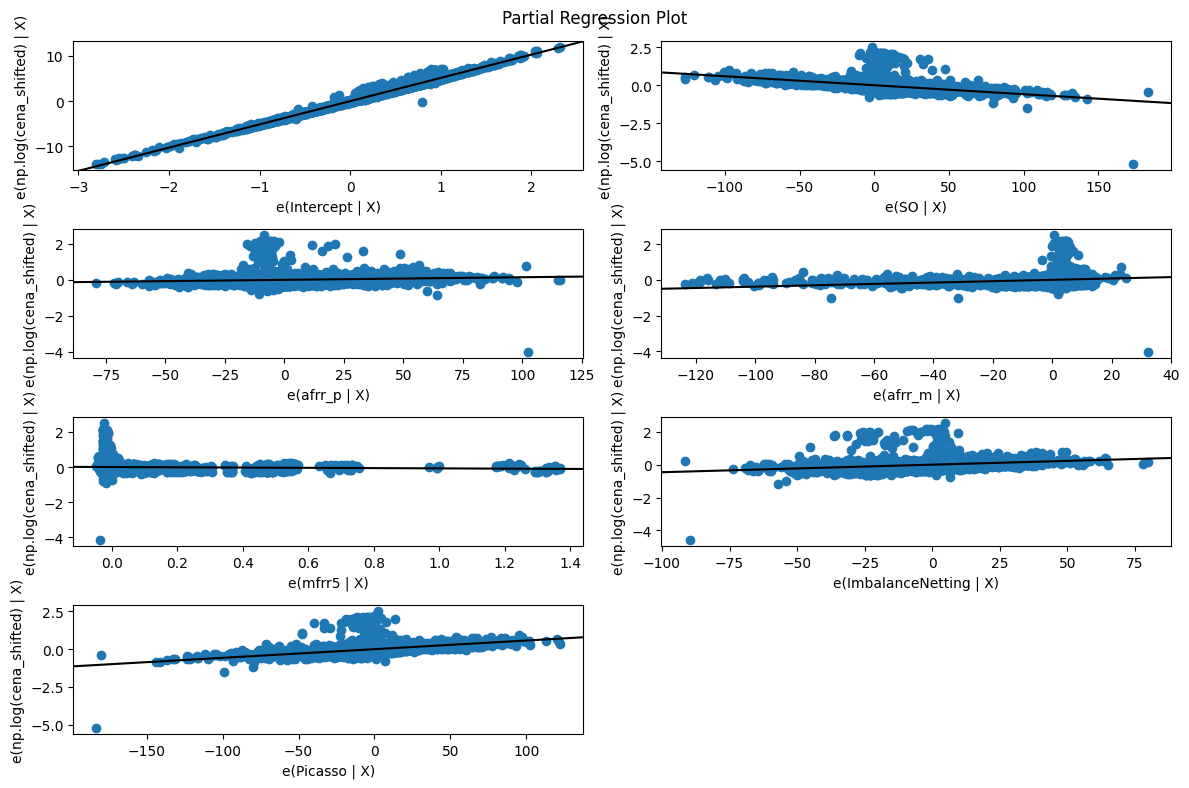

In [11]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12, 8))
sm.graphics.plot_partregress_grid(model_shifted, fig=fig)
plt.tight_layout()
plt.show()

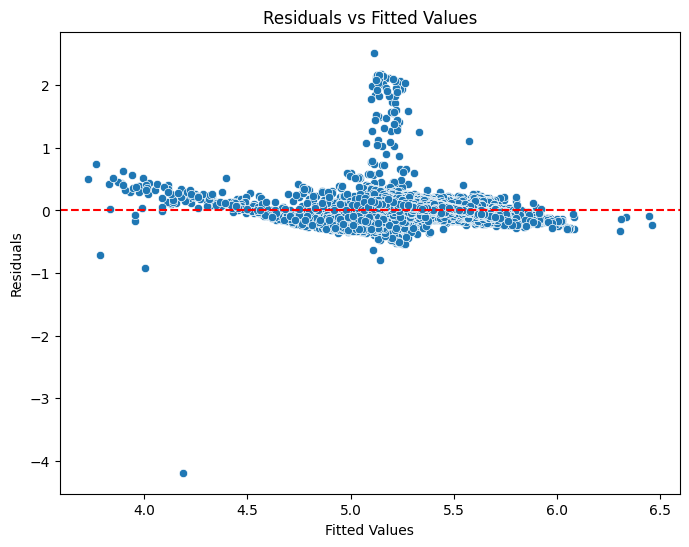

In [12]:
fitted_values = model_shifted.fittedvalues
residuals = model_shifted.resid

plt.figure(figsize=(8, 6))
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add horizontal line at 0
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

In [49]:
def prepare_data_and_model(SVR):
    X = data[['SO', 'afrr_p', 'afrr_m', 'mfrr5', 'ImbalanceNetting', 'Picasso']].values
    #data['cena'] = np.log(data['cena'] - data['cena'].min() + 1)
    y_peak = data[['cena']].values  # Two outputs: extrema and time

    indices_september = data.index

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y_peak, indices_september, test_size=0.2, random_state=42)

    # Standardize the input data
    scaler_X = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)

    scaler_y = StandardScaler()
    y_train = scaler_y.fit_transform(y_train)
    y_test = scaler_y.transform(y_test)

    model_peak = Sequential([
        Input(shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dense(128),
        LeakyReLU(0.01),  # Leaky ReLU activation
        Dense(32),
        LeakyReLU(0.01),  # Leaky ReLU activation
        Dropout(0.1),
        Dense(1)  # Output layer (no activation needed for regression)
    ])

    return X_train, X_test, y_train, y_test, train_indices, test_indices, model_peak, scaler_X, scaler_y

In [43]:
def train_model(X_train, X_test, y_train, y_test, scaler_y, NN_model, lr=0.005, patience_early_stop=10, patience_scheduler=5, num_of_epochs=40, peaks=True):
    if peaks:
        title_suffix = "for Peaks"
        checkpoint_path = "weights_peaks.weights.h5"
    else:
        title_suffix = "for Time"
        checkpoint_path = "weights_time.weights.h5"

    # Create a callback to save the model's weights
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,  # Only save the weights
        monitor='val_loss',      # Monitor validation loss
        mode='min',              # Save weights for minimum val_loss
        save_best_only=True,     # Save only the best weights
        verbose=1
    )

    # Compile the model

    NN_model.compile(optimizer=Adam(learning_rate = lr), loss='mse', metrics=['mse'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience_early_stop, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=patience_scheduler, min_lr=1e-6)
    history = NN_model.fit(X_train, y_train, validation_split=0.2, epochs=num_of_epochs, batch_size=16, callbacks=[early_stopping, lr_scheduler, checkpoint_callback], verbose=1)

    # Evaluate the model
    test_loss, test_mse = NN_model.evaluate(X_test, y_test)
    print(f"Test Mean Squared Error: {test_mse}")

    # Predict and visualize both outputs
    y_pred = NN_model.predict(X_test)

    y_pred = scaler_y.inverse_transform(y_pred)
    y_test = scaler_y.inverse_transform(y_test)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    print(f"Mean Squared Error {title_suffix}: {mse}")


    # Visualize True vs Predicted for Extrema Value
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
    plt.xlabel(f'True Values {title_suffix}')
    plt.ylabel(f'Predicted Values {title_suffix}')
    plt.title(f'True vs Predicted Values {title_suffix}')

    plt.tight_layout()
    plt.show()

In [50]:
X_train, X_test, y_train, y_test, train_indices, test_indices, model_peak, scaler_X, scaler_y = prepare_data_and_model(SVR)

Epoch 1/40
623/635 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8810 - mse: 0.8810
Epoch 1: val_loss improved from inf to 0.37552, saving model to weights_peaks.weights.h5
635/635 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8804 - mse: 0.8804 - val_loss: 0.3755 - val_mse: 0.3755 - learning_rate: 0.0010
Epoch 2/40
613/635 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7460 - mse: 0.7460
Epoch 2: val_loss improved from 0.37552 to 0.36489, saving model to weights_peaks.weights.h5
635/635 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7494 - mse: 0.7494 - val_loss: 0.3649 - val_mse: 0.3649 - learning_rate: 0.0010
Epoch 3/40
624/635 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7496 - mse: 0.7496
Epoch 3: val_loss improved from 0.36489 to 0.36155, saving model to weights_peaks.weights.h5
635/635 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7509 - mse: 0.7509 - val_loss: 0.3616 - val_mse: 0.3616 - learning_rate: 0.0010
Epoch 4/40
629/635 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6869 - mse: 0.6869
Epoch 4:

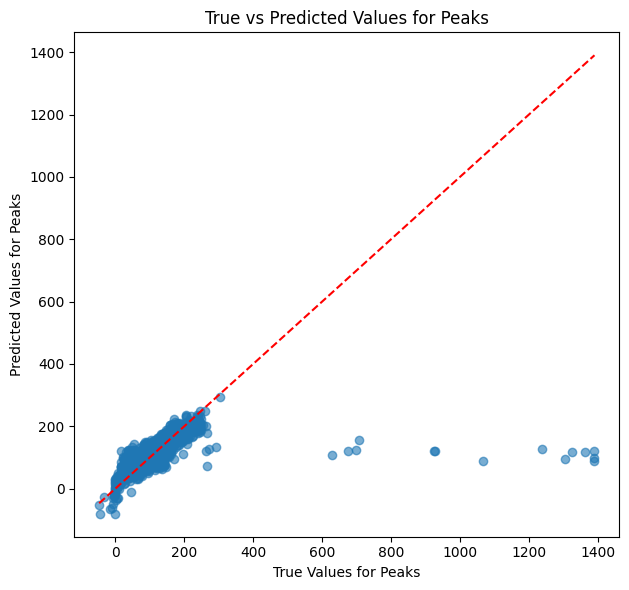

In [51]:
train_model(X_train, X_test, y_train, y_test, scaler_y, model_peak, lr=0.001, patience_early_stop=8, patience_scheduler=4, num_of_epochs=40)